# The bike sharing
## The task is to predict the bike rental demand (regression problem)
### Datasets used: [Bike Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)
+ This notebook is based upon the hourly data file, i.e. hour.csv

# Import libraries

In [17]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.tree import export_graphviz

import scipy.stats as stats

import pydotplus 

%matplotlib inline

rand_state = 42

# Load data set

In [2]:
bike_df = pd.read_csv('hour.csv')
pd.set_option('precision',3)

# Exploratory data analysis

In [3]:
bike_df.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.288,0.81,0.00,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.273,0.80,0.00,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.273,0.80,0.00,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.288,0.75,0.00,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.288,0.75,0.00,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.258,0.75,0.09,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.273,0.80,0.00,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.258,0.86,0.00,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.288,0.75,0.00,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.348,0.76,0.00,8,6,14


+ take a look at data
+ data seems to have loaded correctly

In [5]:
bike_df.shape

(17379, 17)

In [5]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


+ look for cols, that need to be type-casted
+ categorical and data columns need to be type-casted

check if dataset has any cols or rows with nan values

In [6]:
print('Columns with NaN values:',end=' ')
bike_df.columns[bike_df.isnull().any()].tolist()

Columns with NaN values: 

[]

In [7]:
print('Number of rows with NaN values:',end=' ')
print(len(pd.isnull(bike_df).any(axis=1).nonzero()[0].tolist()))
# check if dataset has any rows with nan values

Number of rows with NaN values: 0


<h5>Rename columns to make them look pythonic</h5>

In [3]:
bike_df.rename(
    columns={
        'instant': 'rec_id',
        'dteday': 'datetime',
        'holiday': 'is_holiday',
        'workingday': 'is_workingday',
        'weathersit': 'weather_condition',
        'hum': 'humidity',
        'mnth': 'month',
        'cnt': 'total_count',
        'hr': 'hour',
        'yr': 'year'
    },
    inplace=True)

In [76]:
bike_df.columns.tolist()

['rec_id',
 'datetime',
 'season',
 'year',
 'month',
 'hour',
 'is_holiday',
 'weekday',
 'is_workingday',
 'weather_condition',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'casual',
 'registered',
 'total_count']

### Сheck some statistical properties of the  dataset

In [23]:
bike_df.describe()

,rec_id,temp,atemp,humidity,windspeed,casual,registered,total_count
count,17379.000,17379.000,17379.000,17379.000,17379.000,17379.000,17379.000,17379.000
mean,8690.000,0.497,0.476,0.627,0.190,35.676,153.787,189.463
std,5017.029,0.193,0.172,0.193,0.122,49.305,151.357,181.388
min,1.000,0.020,0.000,0.000,0.000,0.000,0.000,1.000
25%,4345.500,0.340,0.333,0.480,0.104,4.000,34.000,40.000
50%,8690.000,0.500,0.485,0.630,0.194,17.000,115.000,142.000
75%,13034.500,0.660,0.621,0.780,0.254,48.000,220.000,281.000
max,17379.000,1.000,1.000,1.000,0.851,367.000,886.000,977.000


+ As stated on the UCI dataset page, the following attributes have been normalized (same is confirmed above):
    + temp, atemp
    + humidity
    + windspeed

# Type-cast attributes

In [4]:
# cast to data attributes
bike_df['datetime'] = pd.to_datetime(bike_df['datetime'])

# cast to categorical attributes
bike_df['season'] = bike_df['season'].astype('category')
bike_df['year'] = bike_df['year'].astype('category')
bike_df['month'] = bike_df['month'].astype('category')
bike_df['hour'] = bike_df['hour'].astype('category')
bike_df['is_holiday'] = bike_df['is_holiday'].astype('category')
bike_df['weekday'] = bike_df['weekday'].astype('category')
bike_df['is_workingday'] = bike_df['is_workingday'].astype('category')
bike_df['weather_condition'] = bike_df['weather_condition'].astype('category')

# Data visualization

### histogram + density

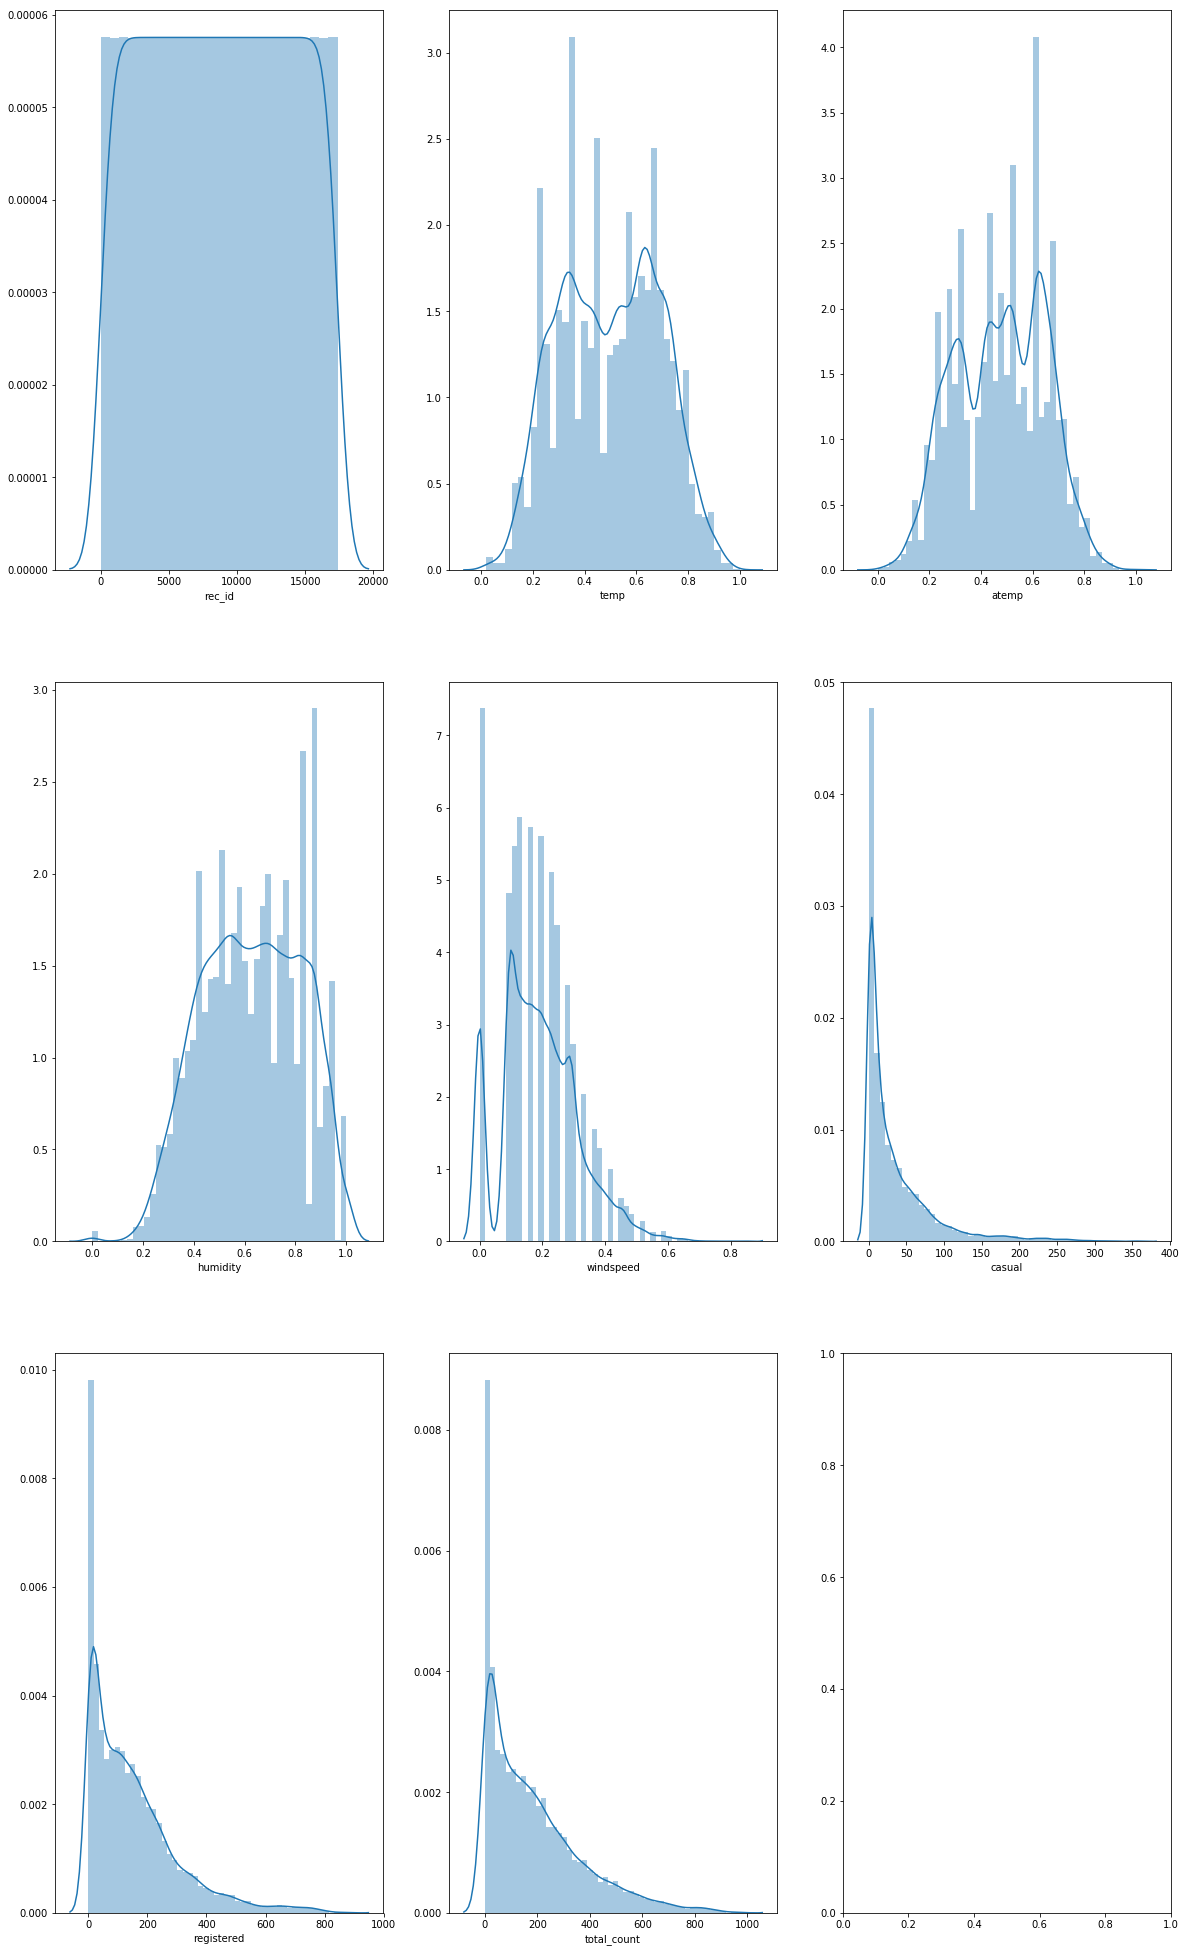

In [12]:
n_rows, n_cols = 3, 3
fig, axes = plt.subplots(ncols=n_cols,nrows=n_rows,sharex=False,sharey=False,figsize=(20,35))

curr_row, curr_col = 0, 0
for name in bike_df.select_dtypes(exclude=['datetime','category']).columns:
    sns.distplot(a=bike_df[name],ax=axes[curr_row][curr_col])
    curr_col+=1
    if curr_col==n_cols:
        curr_row+=1
        curr_col=0

+ windspeed, casual, registered and total_count seem to have an exponential distribution

## Hourly distributions of total counts
+ 1: Spring, 2: Summer, 3: Autumn, 4: Winter

[Text(0.5,1,'Season wise hourly distribution of counts')]

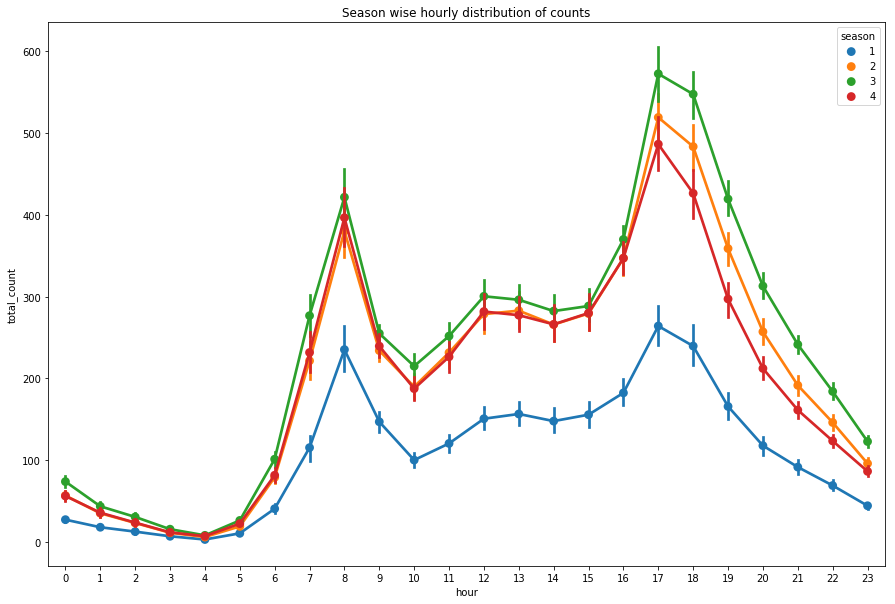

In [13]:
fig, ax = plt.subplots(figsize=(15,10))
sns.pointplot(data=bike_df[['hour','total_count','season']],x='hour',y='total_count',hue='season',ax=ax)
ax.set(title='Season wise hourly distribution of counts')

### we can see peaks at 7-9 am and 4-6 pm, probably due to start and end of the working day
### the counts are the lowest during spring and the highest in Autumn across all 24hrs

[Text(0.5,1,'Weekday wise hourly distribution of counts')]

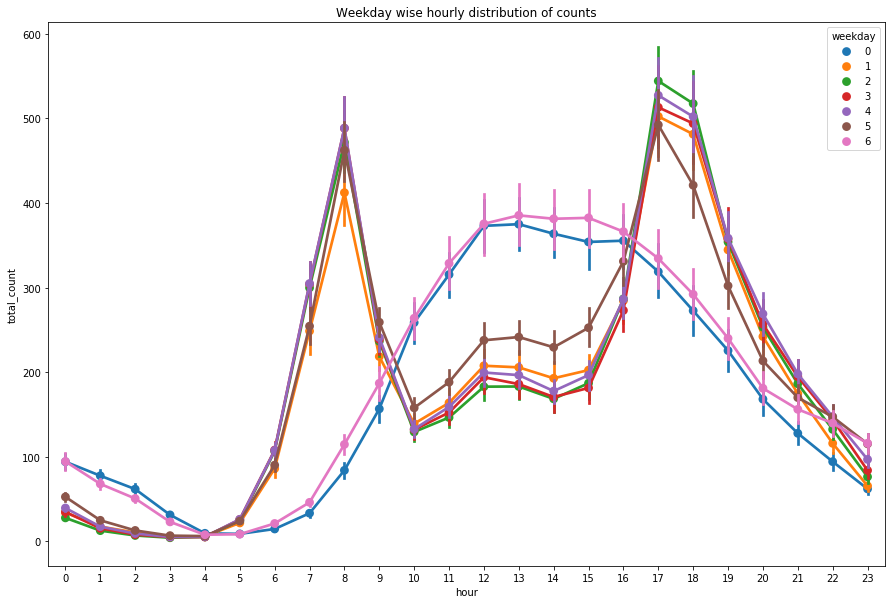

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
sns.pointplot(data=bike_df[['hour','total_count','weekday']],x='hour',y='total_count',hue='weekday',ax=ax)
ax.set(title='Weekday wise hourly distribution of counts')

from the plot we can see that:
+ during workdays there are peaks at 7-9 am and 5-7 pm 
+ during weekends people tend to rent bicycles during midday
+ days 0-4 have different patterns compared to 5-6

[Text(0.5,1,'Monthly count distributions')]

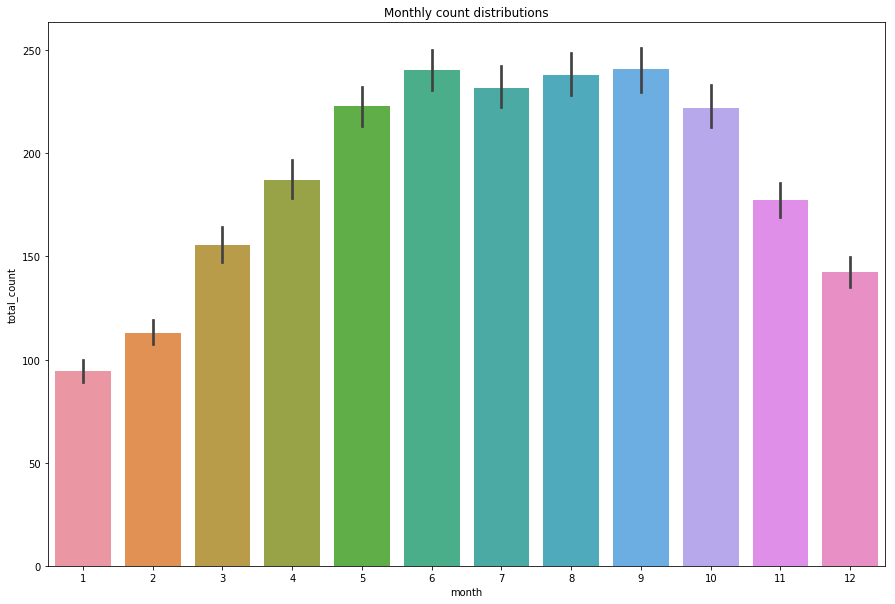

In [15]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=bike_df[['month','total_count']],x='month',y='total_count')
ax.set(title='Monthly count distributions')

it can be seen that the bike usage is definitely higher during middle and late months of the  year

[Text(0.5,1,'Counts to hour plot for Winter')]

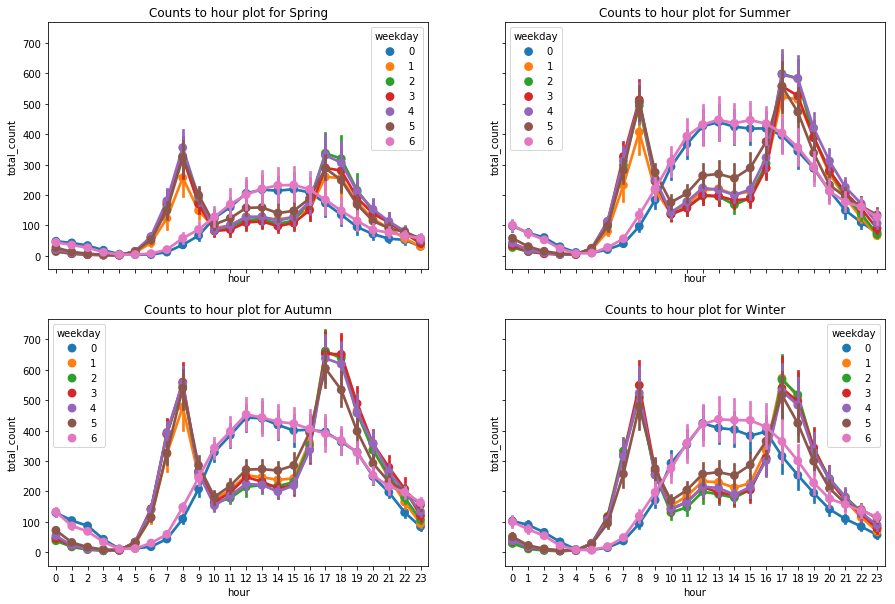

In [16]:
fig, ax = plt.subplots(
    nrows=2, ncols=2, sharex=True, sharey=True, figsize=(15, 10))

ax1 = sns.pointplot(
    data=bike_df[bike_df['season'] == 1][['hour', 'total_count', 'weekday']],
    x='hour',
    y='total_count',
    hue='weekday',
    ax=ax[0][0])
ax1.set(title='Counts to hour plot for Spring')

ax2 = sns.pointplot(
    data=bike_df[bike_df['season'] == 2][['hour', 'total_count', 'weekday']],
    x='hour',
    y='total_count',
    hue='weekday',
    ax=ax[0][1])
ax2.set(title='Counts to hour plot for Summer')

ax3 = sns.pointplot(
    data=bike_df[bike_df['season'] == 3][['hour', 'total_count', 'weekday']],
    x='hour',
    y='total_count',
    hue='weekday',
    ax=ax[1][0])
ax3.set(title='Counts to hour plot for Autumn')

ax4 = sns.pointplot(
    data=bike_df[bike_df['season'] == 4][['hour', 'total_count', 'weekday']],
    x='hour',
    y='total_count',
    hue='weekday',
    ax=ax[1][1])
ax4.set(title='Counts to hour plot for Winter')

+ we can see similar patterns in data for all seasons, except bike usage seems to be lower in Spring

[Text(0.5,1,'Counts to hour plot for Winter')]

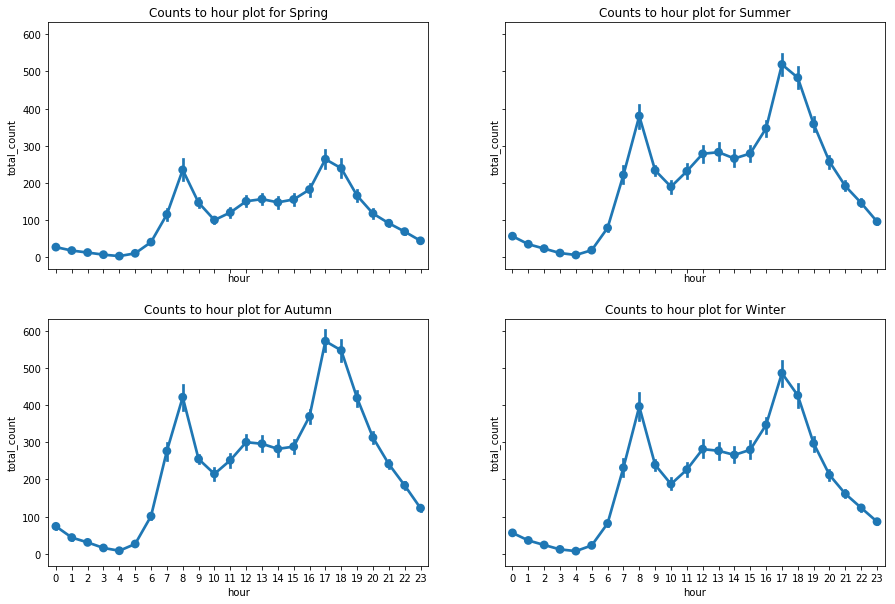

In [17]:
fig, ax = plt.subplots(
    nrows=2, ncols=2, sharex=True, sharey=True, figsize=(15, 10))

ax1 = sns.pointplot(
    data=bike_df[bike_df['season'] == 1][['hour', 'total_count']],
    x='hour',
    y='total_count',
    ax=ax[0][0])
ax1.set(title='Counts to hour plot for Spring')

ax2 = sns.pointplot(
    data=bike_df[bike_df['season'] == 2][['hour', 'total_count']],
    x='hour',
    y='total_count',
    ax=ax[0][1])
ax2.set(title='Counts to hour plot for Summer')

ax3 = sns.pointplot(
    data=bike_df[bike_df['season'] == 3][['hour', 'total_count']],
    x='hour',
    y='total_count',
    ax=ax[1][0])
ax3.set(title='Counts to hour plot for Autumn')

ax4 = sns.pointplot(
    data=bike_df[bike_df['season'] == 4][['hour', 'total_count']],
    x='hour',
    y='total_count',
    ax=ax[1][1])
ax4.set(title='Counts to hour plot for Winter')

+ again, similar patterns in data, but bike usage in winter is lower

# Violinplot

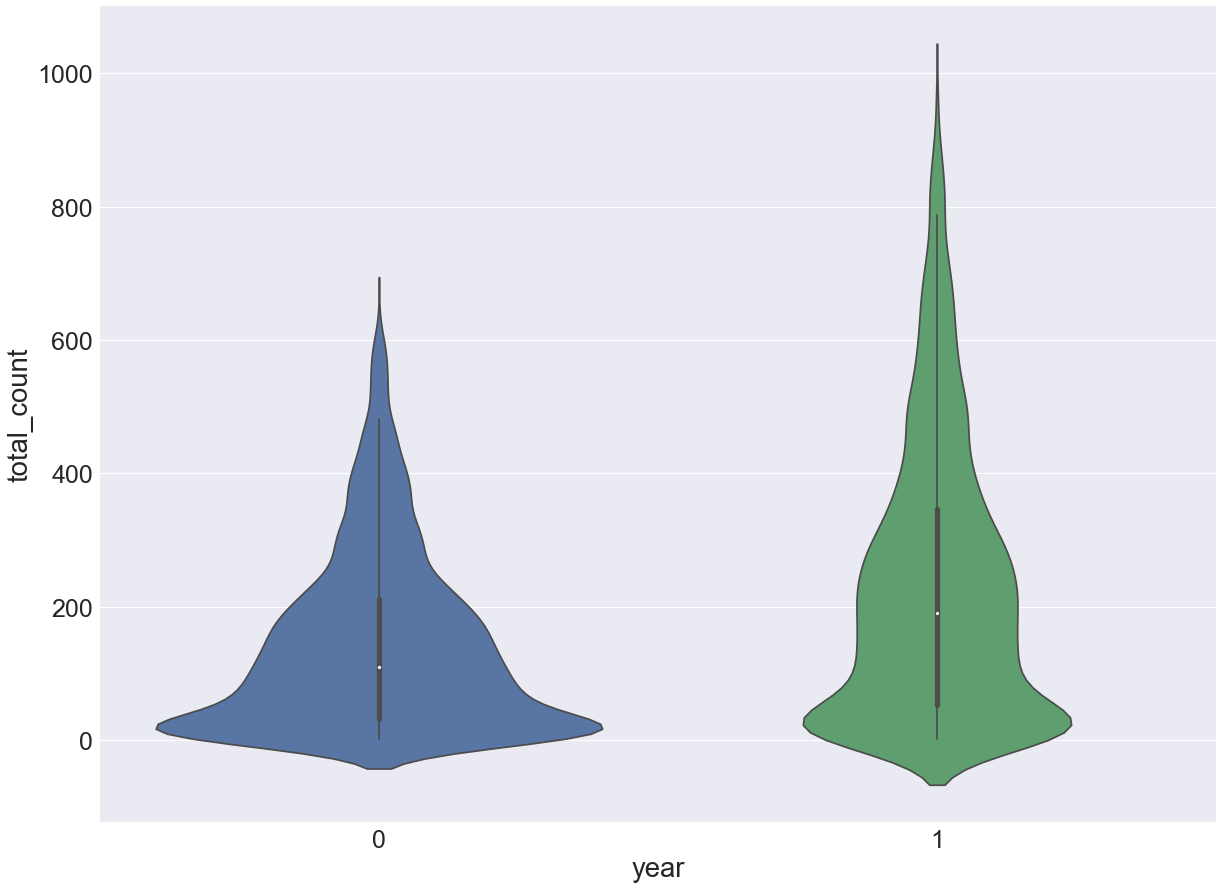

In [25]:
fig, ax = plt.subplots(figsize=(20,15))
sns.violinplot(data=bike_df[['year','total_count']],x='year',y='total_count',ax=ax)

+ both have multimodal distribution
+ average usage 100-200 in both
+ 1 has bigger spread
+ 0 has lower peaks, lower median and counts

# Outliers

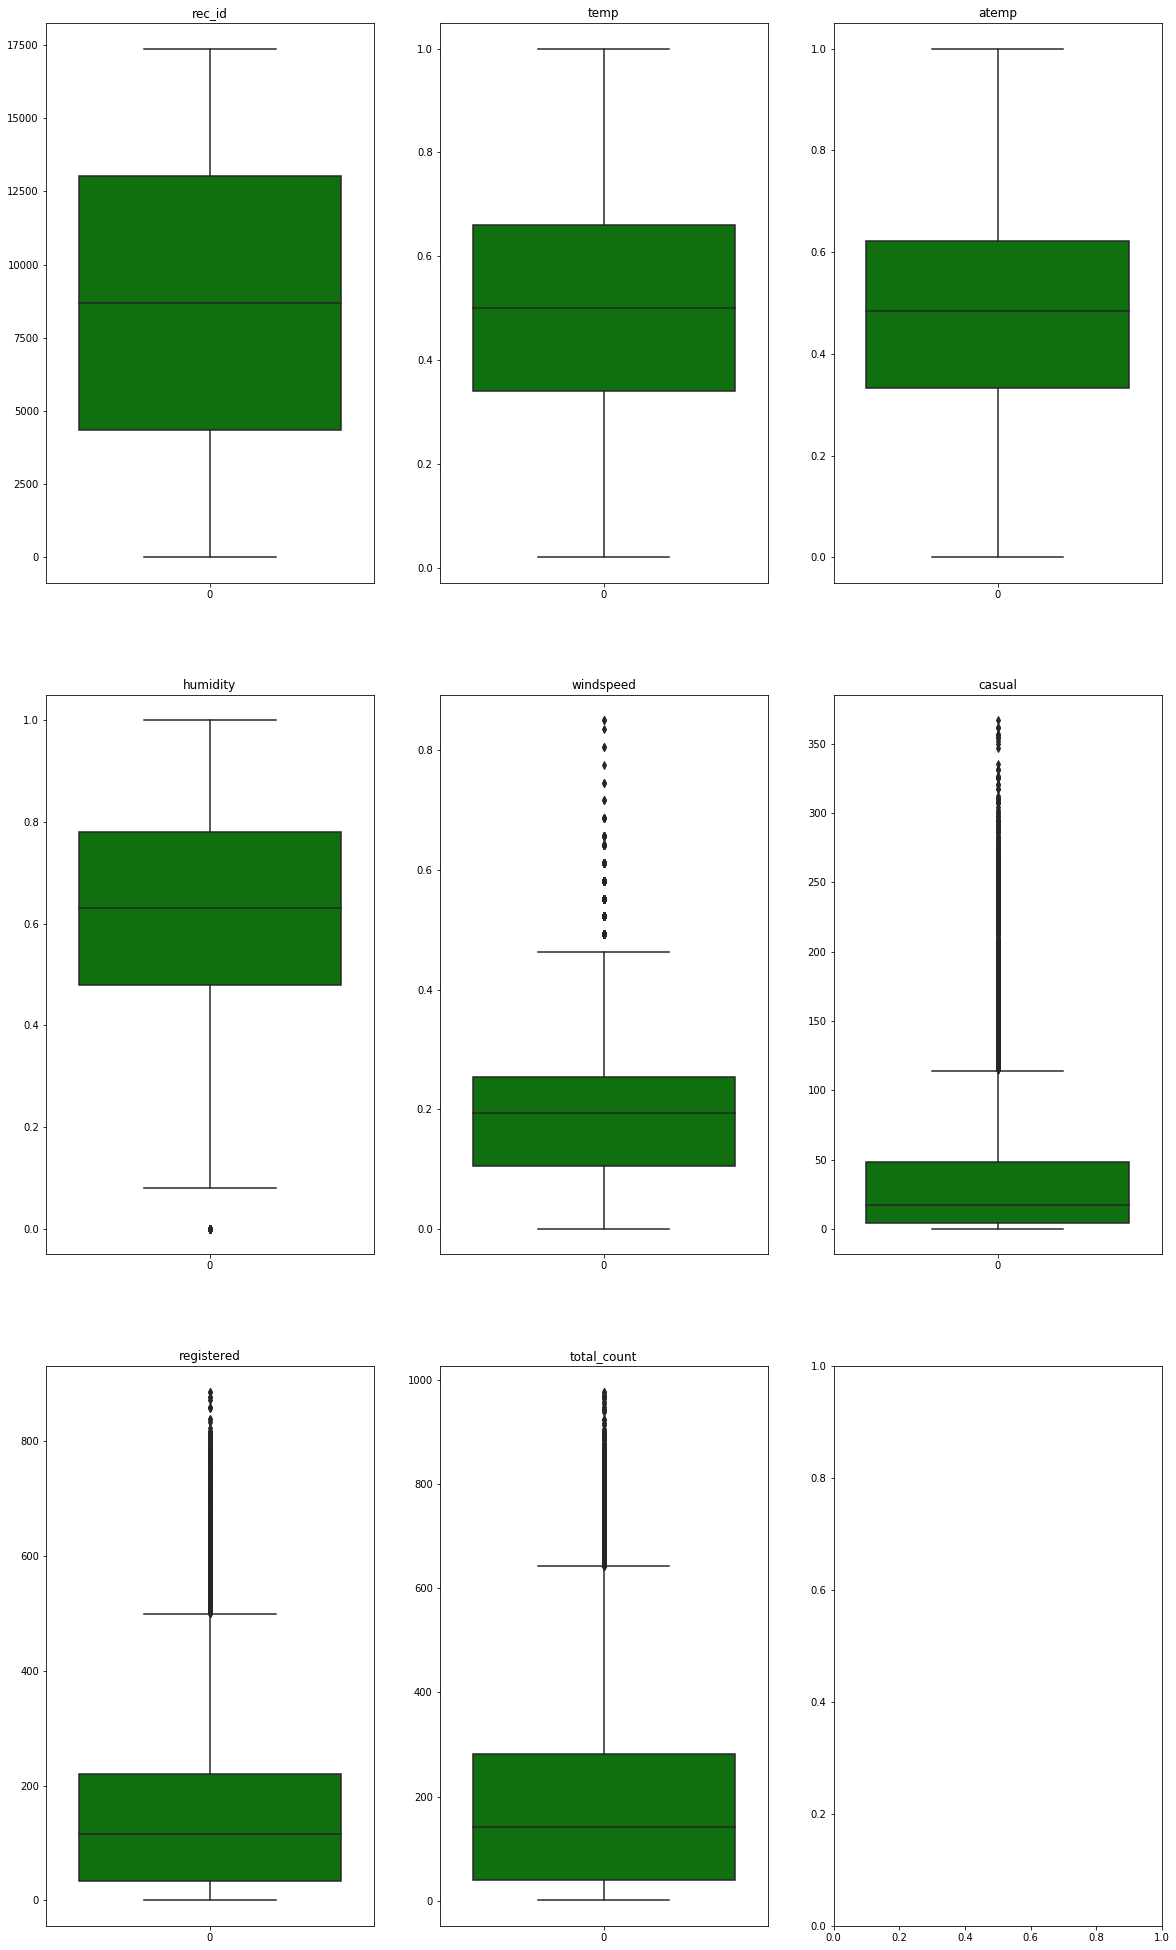

In [19]:
n_rows, n_cols = 3, 3
fig, axes = plt.subplots(ncols=n_cols,nrows=n_rows,sharex=False,sharey=False,figsize=(20,35))

curr_row, curr_col = 0, 0
for name in bike_df.select_dtypes(exclude=['datetime','category']).columns:
    sns.boxplot(data=bike_df[name],ax=axes[curr_row][curr_col],color='g')
    axes[curr_row][curr_col].set(title=name)
    curr_col+=1
    if curr_col==n_cols:
        curr_row+=1
        curr_col=0

+ numeric attributes have some outliers
+ weather attributes like windspeed have outliers too

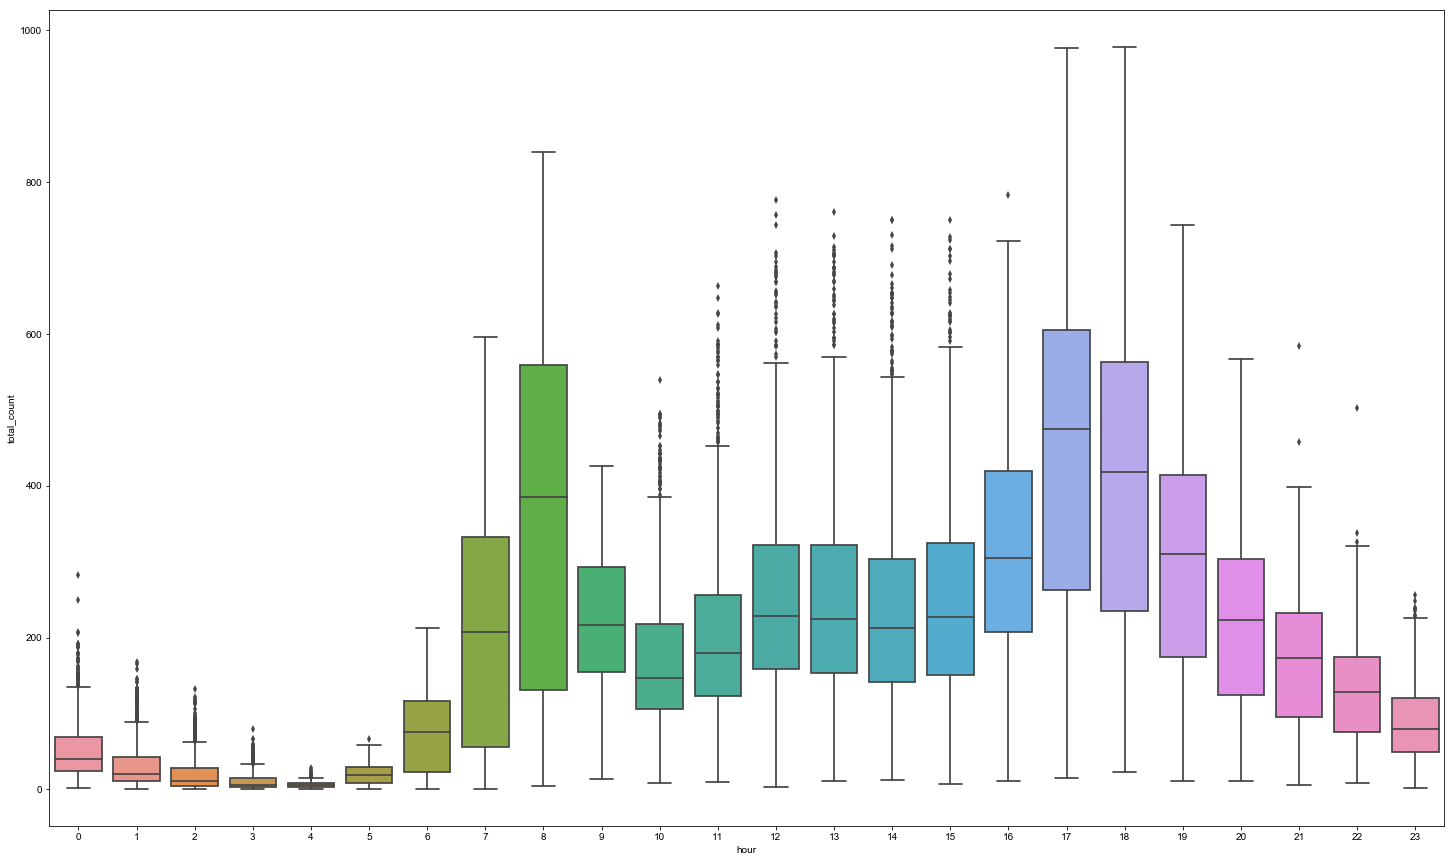

In [20]:
fig, ax = plt.subplots(figsize=(25,15))
sns.set(font_scale=2.5)
sns.boxplot(data=bike_df[['total_count','hour']],x='hour',y='total_count')

+ early hours (0-4) and late hours (21-23) have low rental values but significant outliers
+ peek hours have high median and rental values, and no outliers
+ afternoon hours have outliers

# Correlations

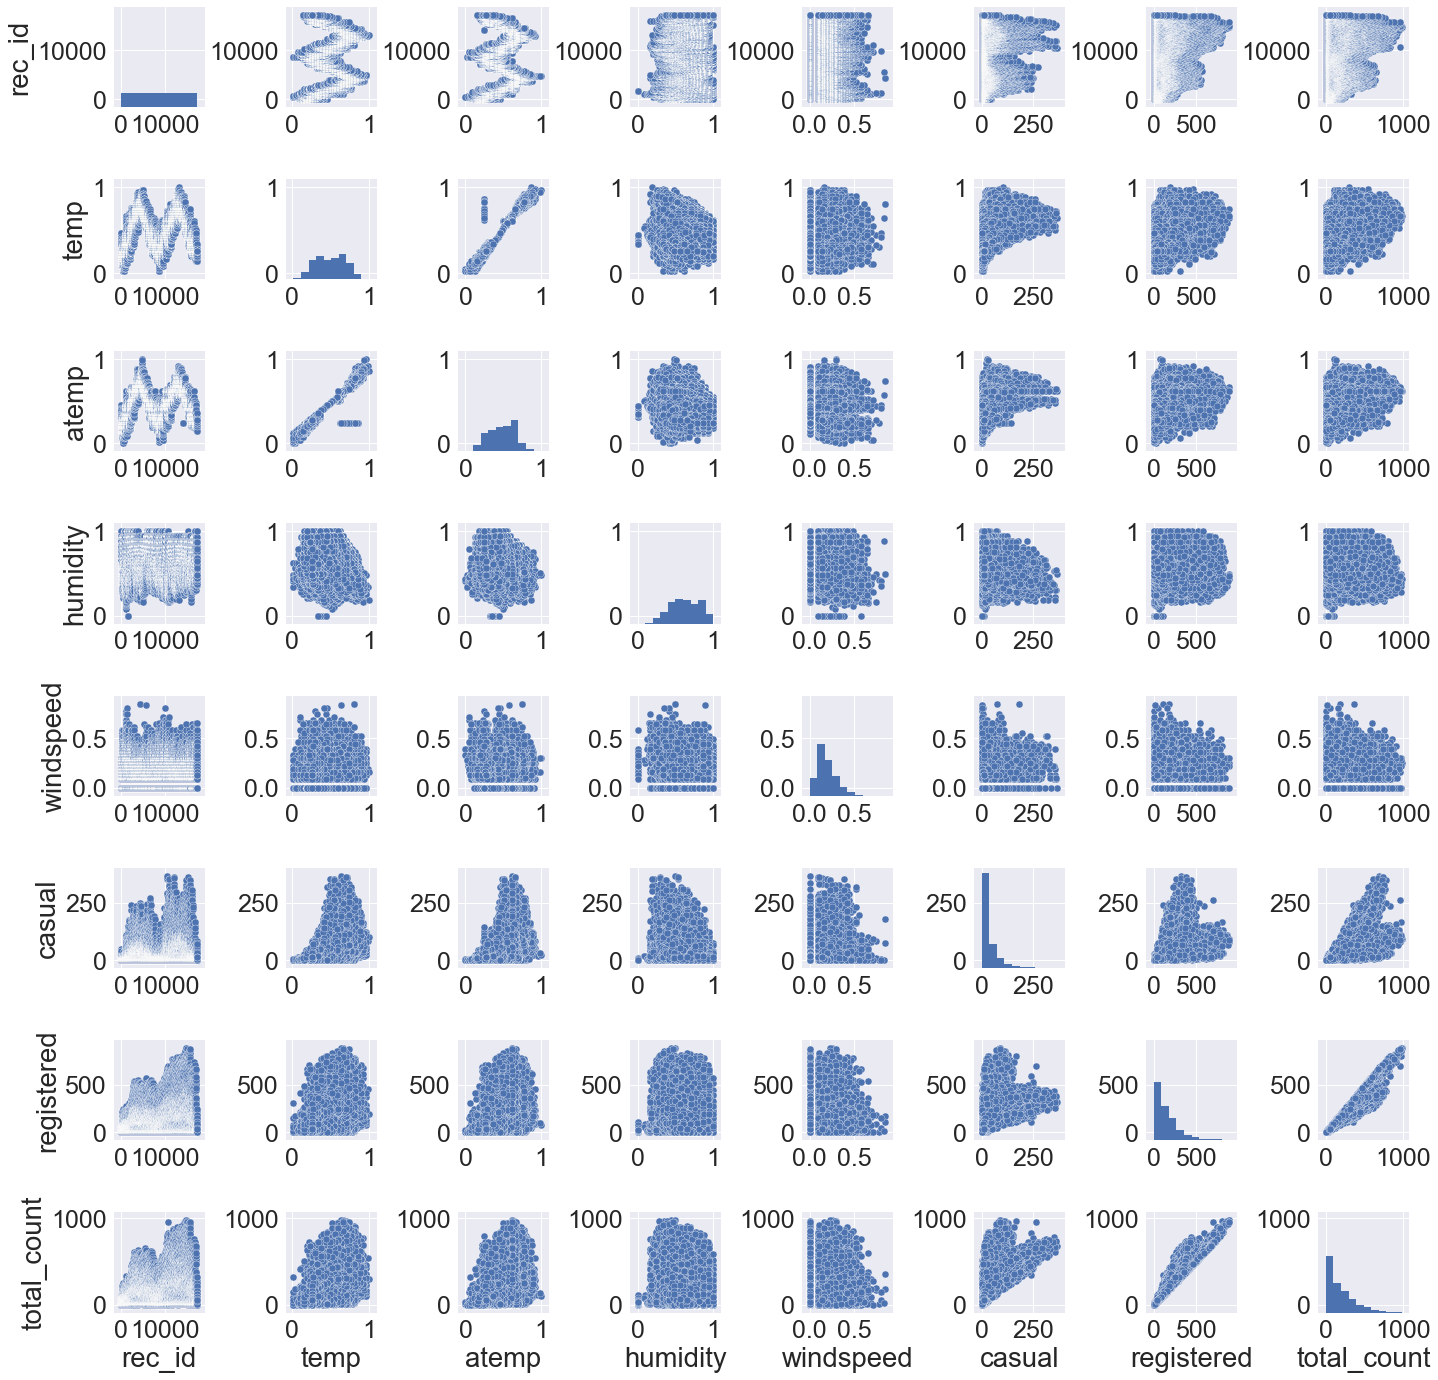

In [21]:
sns.pairplot(data=bike_df[bike_df.select_dtypes(exclude=['datetime','category']).columns])

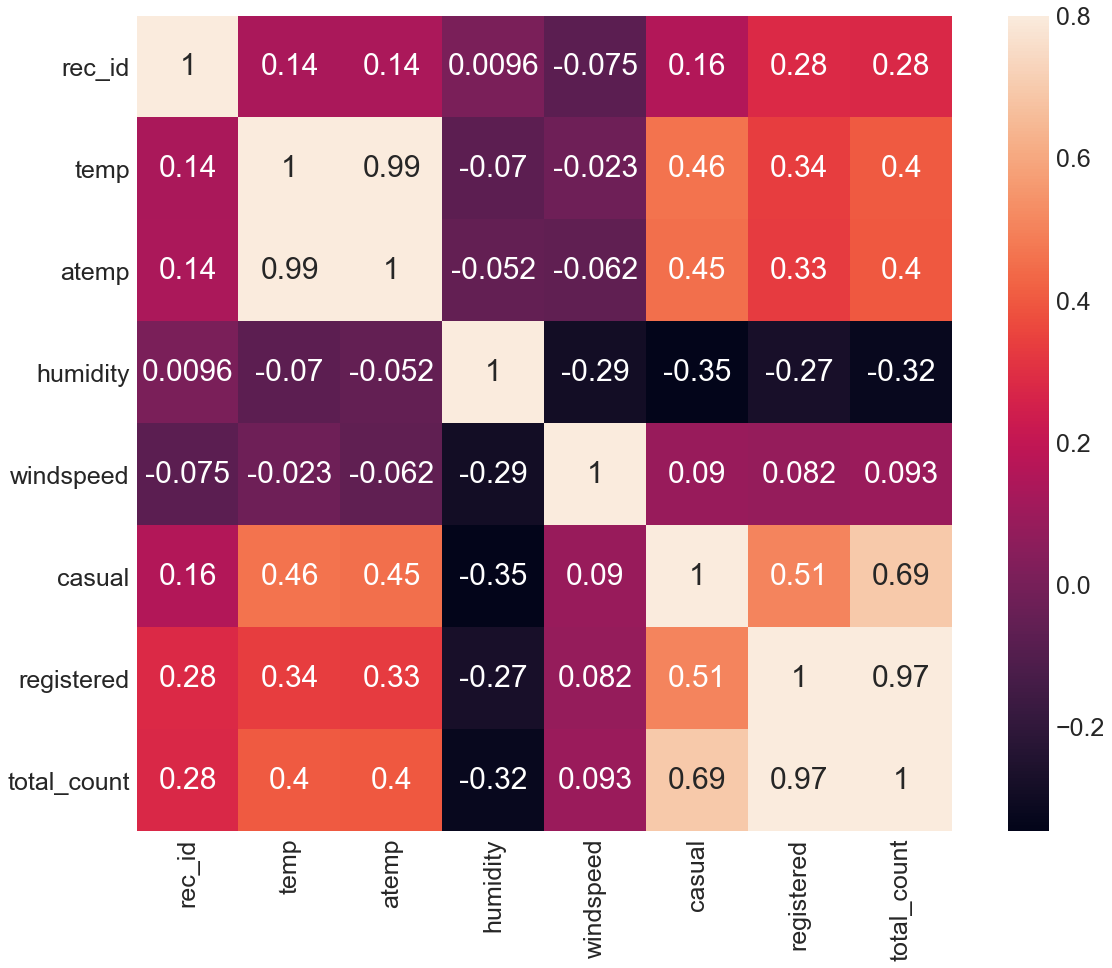

In [26]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(
    data=bike_df[bike_df.select_dtypes(
        exclude=['datetime', 'category']).columns].corr(),
    annot=True,
    ax=ax,
    vmax=0.8,
    square=True)



+ calual and registered show corr to total_count
+ humidity has negative corrs with some attributes
+ Correlation between temp and atemp is very high (as expected)
+ overall correlation statistics are not very high

# Regression analysis

Before applying regression we have to transform categorical features, so they can be accepted by the algorithm

In [5]:
def fit_transform_ohe(df, col_name):
    # label encode the column
    le = LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name + '_label'] = le_labels

    # one-hot transform
    ohe = OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name + '_label']]).toarray()
    feature_labels = [col_name + '_' + str(class_) for class_ in le.classes_]
    feature_df = pd.DataFrame(feature_arr, columns=feature_labels)

    return le, ohe, feature_df


def transform_ohe(df, le, ohe, col_name):
    # label encode the columns
    le_labels = le.transform(df[col_name])
    df[col_name + '_label'] = le_labels

    # one-hot encoding
    feature_array = ohe.transform(df[[col_name + '_label']]).toarray()
    feature_labels = [col_name + '_' + str(class_) for class_ in le.classes_]
    feature_df = pd.DataFrame(feature_array, columns=feature_labels)

    return feature_df

# Train-test split

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(bike_df.iloc[:,0:-3], bike_df.iloc[:,-1], 
                                                    test_size=0.33, random_state=rand_state)

X_train.reset_index(inplace=True)
Y_train = Y_train.reset_index()

X_test.reset_index(inplace=True)
Y_test = Y_test.reset_index()

print('Training set::{}{}'.format(X_train.shape,Y_train.shape))
print('Testing set::{}{}'.format(X_test.shape,Y_test.shape))

Training set::(11643, 15)(11643, 2)
Testing set::(5736, 15)(5736, 2)


# Normality test

((array([-3.84804698, -3.62496034, -3.50257881, ...,  3.50257881,
          3.62496034,  3.84804698]),
  array([  1,   1,   1, ..., 967, 968, 976])),
 (170.86865931712518, 191.21875805204837, 0.9349126985486736))

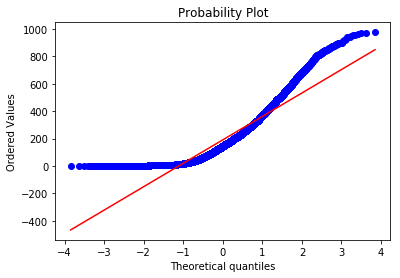

In [24]:
stats.probplot(Y_train.total_count.tolist(), dist="norm", plot=plt)

## Preprocessing
+ Encode Categoricals using One Hot Encoding

# Encode categorical features

In [7]:
categorical_features_names = [
    'season', 'year', 'month', 'hour', 'is_holiday', 'weekday',
    'is_workingday', 'weather_condition'
]

numeric_feature_cols = ['temp','humidity','windspeed','hour','weekday','month','year']

subset_categorical_feature_names = [
    'season', 'is_holiday', 'is_workingday', 'weather_condition'
]
# ordinal values don't need to be encoded

In [8]:
encoded_list_features = []
for col_name in categorical_features_names:
    return_obj = fit_transform_ohe(X_train, col_name)
    encoded_list_features.append({
        'label_enc': return_obj[0],
        'ohe_enc': return_obj[1],
        'feature_df': return_obj[2],
        'col_name': col_name
    })

In [9]:
feature_df_list = [X_train[numeric_feature_cols]]
feature_df_list.extend(enc['feature_df']\
                      for enc in encoded_list_features \
                      if enc['col_name'] in subset_categorical_feature_names)

train_df_new = pd.concat(feature_df_list,axis=1)
print('Shape::{}'.format(train_df_new.shape))

Shape::(11643, 19)


# Training

In [10]:
X = train_df_new
Y = Y_train.total_count.values.reshape(-1,1)

lin_reg = LinearRegression()

# Cross validation

Text(0,0.5,'Residual')

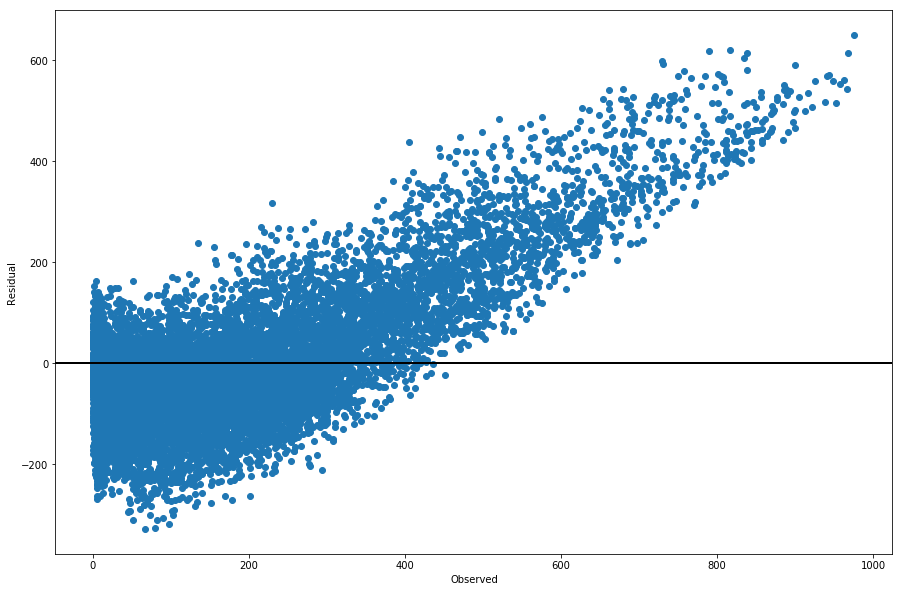

In [11]:
predicted = cross_val_predict(lin_reg, X,Y,cv=10)

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(Y,Y-predicted)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')

The plot violates the homoscedasticity assumption, which is about residuals being random and not following any pattern

In [27]:
r2_scores = cross_val_score(lin_reg,X,Y,cv=10)
mse_scores = cross_val_score(lin_reg,X,Y,cv=10,scoring='neg_mean_squared_error')

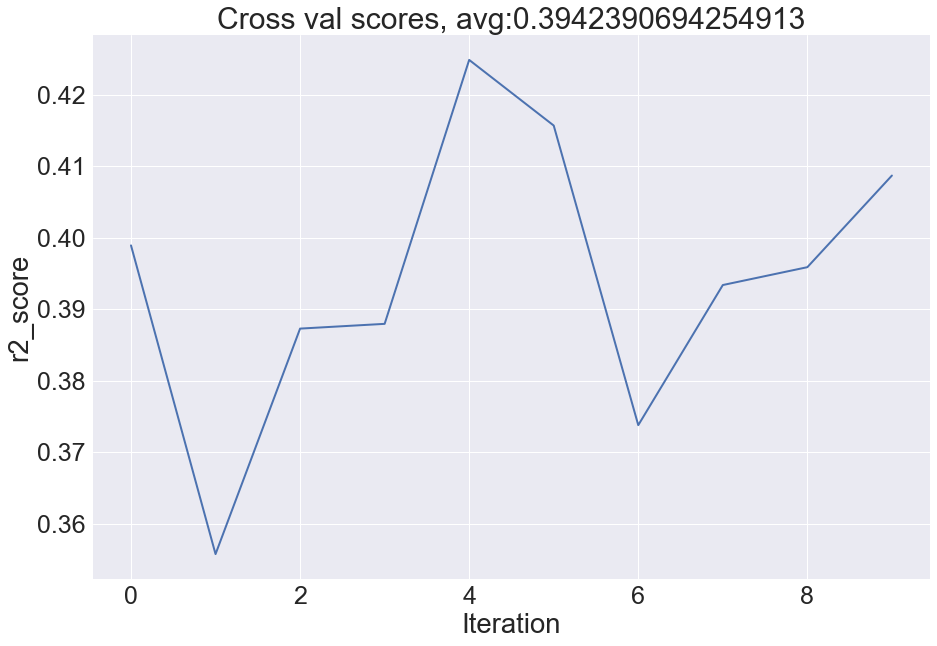

In [134]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot([i for i in range(len(r2_scores))],r2_scores,lw=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('r2_score')
ax.title.set_text('Cross val scores, avg:{}'.format(np.average(r2_scores)))

In [28]:
print('R2: {}'.format(np.average(r2_scores)))
print('MSE: {}'.format(np.average(-1*mse_scores)))

R2: 0.3942390694254913
MSE: 20203.751111588306


In [11]:
lin_reg.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

# Testing

In [149]:
X_test.head()

,index,rec_id,datetime,season,year,month,hour,is_holiday,weekday,is_workingday,weather_condition,temp,atemp,humidity,windspeed,season_label
0,12830,12831,2012-06-23,3,1,6,19,0,6,0,1,0.80,0.697,0.27,0.194,2
1,8688,8689,2012-01-02,1,1,1,20,1,1,0,1,0.24,0.227,0.41,0.224,0
2,7091,7092,2011-10-28,4,0,10,2,0,5,1,1,0.32,0.303,0.66,0.284,3
3,12230,12231,2012-05-29,2,1,5,19,0,2,1,1,0.78,0.712,0.52,0.358,1
4,431,432,2011-01-20,1,0,1,0,0,4,1,1,0.26,0.227,0.56,0.388,0


## Preprocessing for test set

In [12]:
test_enc_features_list = []
for enc in encoded_list_features:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_enc_features_list.append({
        'feature_df':
        transform_ohe(X_test, le, ohe, col_name),
        'col_name':
        col_name
    })

test_feature_list = [X_test[numeric_feature_cols]]
test_feature_list.extend([enc['feature_df']\
                               for enc in test_enc_features_list \
                              if enc['col_name']in subset_categorical_feature_names])
test_df_new = pd.concat(test_feature_list, axis=1)

In [41]:
test_df_new.head()

,temp,humidity,windspeed,hour,weekday,month,year,season_1,season_2,season_3,season_4,is_holiday_0,is_holiday_1,is_workingday_0,is_workingday_1,weather_condition_1,weather_condition_2,weather_condition_3,weather_condition_4
0,0.80,0.27,0.194,19,6,6,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.24,0.41,0.224,20,1,1,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.32,0.66,0.284,2,5,10,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.78,0.52,0.358,19,2,5,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.26,0.56,0.388,0,4,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [13]:
new_x_test = test_df_new
new_y_test = Y_test.total_count.values.reshape(-1,1)

y_pred = lin_reg.predict(new_x_test)

residuals = new_y_test - y_pred
r2_score = lin_reg.score(new_x_test,new_y_test)

In [39]:
print('R2: {}'.format(np.average(r2_score)))
print('MSE: {}'.format(mean_squared_error(y_pred,new_y_test)))

R2: 0.4024409682673428
MSE: 19062.99975600927


Text(0,0.5,'Residual')

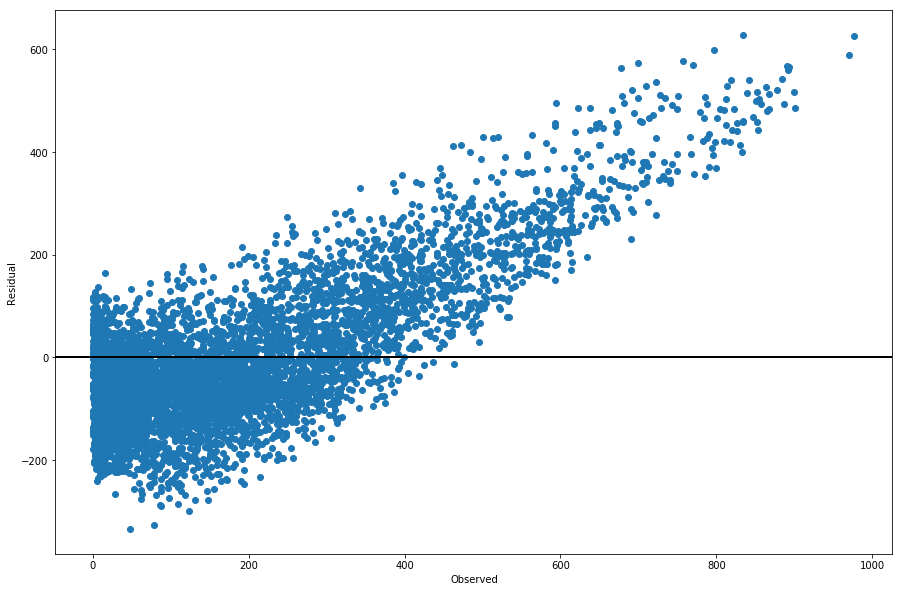

In [33]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(new_y_test,residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')

Now it should be clear that a linear model can't fit this problem

### Possibilities for future linear modeling:
+ select different subsets of attributes and repeat steps for them'

# Stats model

In [47]:
import statsmodels.api as sm

# Set the independent variable
X = X.values.tolist()

# This handles the intercept. 
# Statsmodel takes 0 intercept by default
X = sm.add_constant(X)

new_x_test = new_x_test.values.tolist()
new_x_test = sm.add_constant(new_x_test)


# Build OLS model
model = sm.OLS(Y, X)
results = model.fit()

# Get the predicted values for dependent variable
pred_y = results.predict(new_x_test)

# View Model stats
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     508.2
Date:                Thu, 31 May 2018   Prob (F-statistic):               0.00
Time:                        16:38:11   Log-Likelihood:                -74221.
No. Observations:               11643   AIC:                         1.485e+05
Df Residuals:                   11627   BIC:                         1.486e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3509     11.086     -0.122      0.9

In [77]:
stats_residuals = new_y_test.flatten() - pred_y

Text(0,0.5,'Residual')

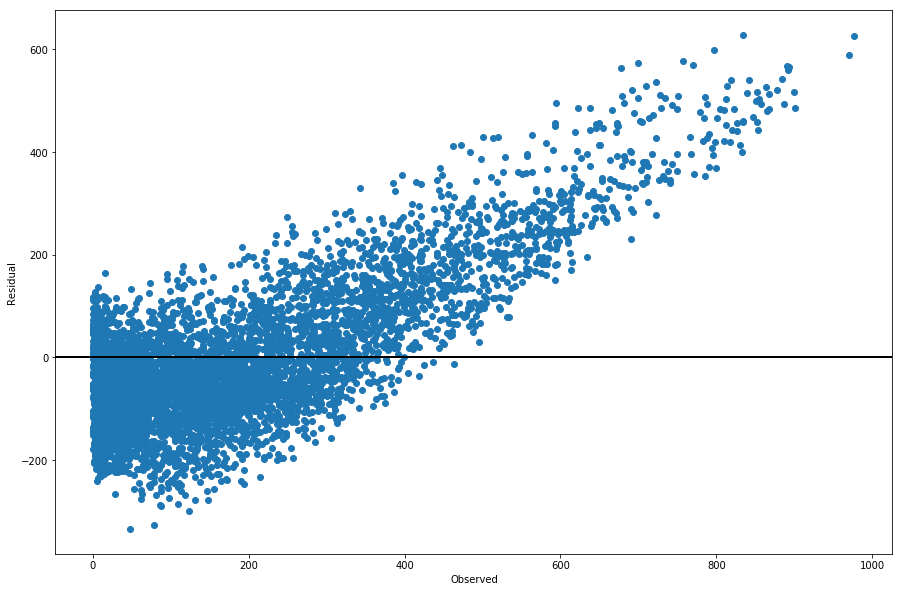

In [79]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(new_y_test,stats_residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')

# Decision tree based regression

In [14]:
cart_model = DecisionTreeRegressor(max_depth= 4,min_samples_split=5,max_leaf_nodes=10)
cart_model.fit(X,Y)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [15]:
cart_model.score(X, Y)

0.6056576562103779

## Plot the learnt model

In [16]:
dot_data = export_graphviz(cart_model, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("bikeshare.pdf") 

True

# Tune hyperparametrs for decision tree

In [18]:
param_grid = {
    'criterion': ['mse', 'mae'],
    'min_samples_split': [10, 20, 40],
    'max_depth': [2, 6, 8],
    "min_samples_leaf": [20, 40, 100],
    "max_leaf_nodes": [5, 20, 100, 500, 800]
}
grid_cv_cart_model = GridSearchCV(estimator = cart_model, param_grid=param_grid,cv=5)

In [20]:
grid_cv_cart_model.fit(X,Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['mse', 'mae'], 'min_samples_split': [10, 20, 40], 'max_depth': [2, 6, 8], 'min_samples_leaf': [20, 40, 100], 'max_leaf_nodes': [5, 20, 100, 500, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [23]:
print('R2: {}'.format(grid_cv_cart_model.best_score_))
print('Best hyperparameters: {}'.format(grid_cv_cart_model.best_params_))

R2: 0.85891903233008
Best hyperparameters: {'criterion': 'mse', 'max_depth': 8, 'max_leaf_nodes': 500, 'min_samples_leaf': 20, 'min_samples_split': 10}


In [26]:
grid_cart_model_cv_df = pd.DataFrame(data=grid_cv_cart_model.cv_results_,)
grid_cart_model_cv_df.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.030,3.796e-03,0.005,8.347e-04,mse,2,5,20,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",...,0.484,0.007,217,0.492,0.484,0.489,0.491,0.488,0.489,0.003
1,0.024,3.995e-04,0.004,3.157e-04,mse,2,5,20,20,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",...,0.484,0.007,217,0.492,0.484,0.489,0.491,0.488,0.489,0.003
2,0.024,8.712e-04,0.004,1.210e-06,mse,2,5,20,40,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",...,0.484,0.007,217,0.492,0.484,0.489,0.491,0.488,0.489,0.003
3,0.023,2.444e-04,0.004,2.435e-04,mse,2,5,40,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",...,0.484,0.007,217,0.492,0.484,0.489,0.491,0.488,0.489,0.003
4,0.024,8.356e-04,0.004,2.444e-04,mse,2,5,40,20,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",...,0.484,0.007,217,0.492,0.484,0.489,0.491,0.488,0.489,0.003


[Text(0.5,1,'Affect of depth and leaf nodes on model performance')]

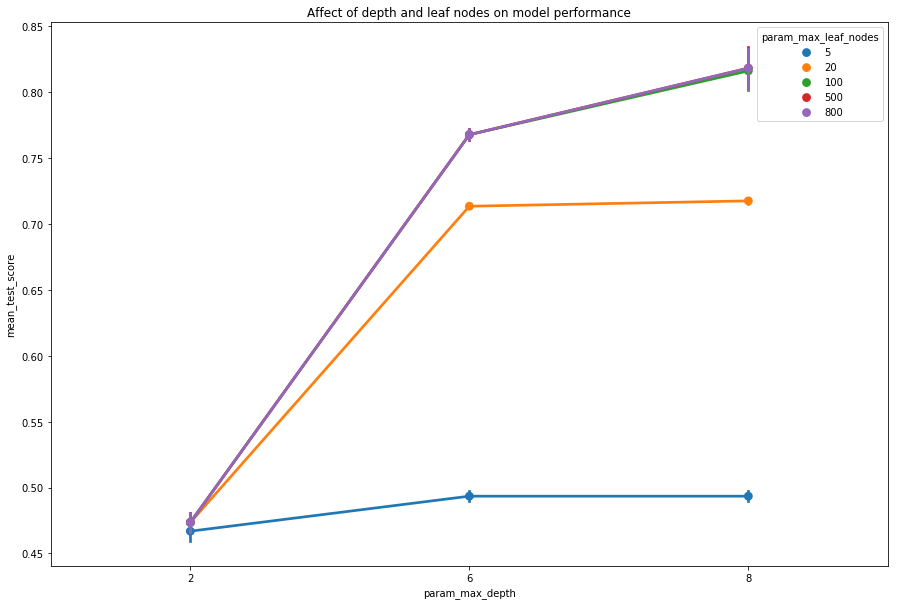

In [28]:
fig, ax = plt.subplots(figsize=(15,10))
sns.pointplot(data=grid_cart_model_cv_df[['mean_test_score','param_max_leaf_nodes','param_max_depth']],y='mean_test_score', 
             x='param_max_depth',hue='param_max_leaf_nodes')
ax.set(title='Affect of depth and leaf nodes on model performance')

# Residual plot

In [29]:
predicted = grid_cv_cart_model.best_estimator_.predict(X)
residuals = Y.flatten() - predicted

Text(0,0.5,'Residual')

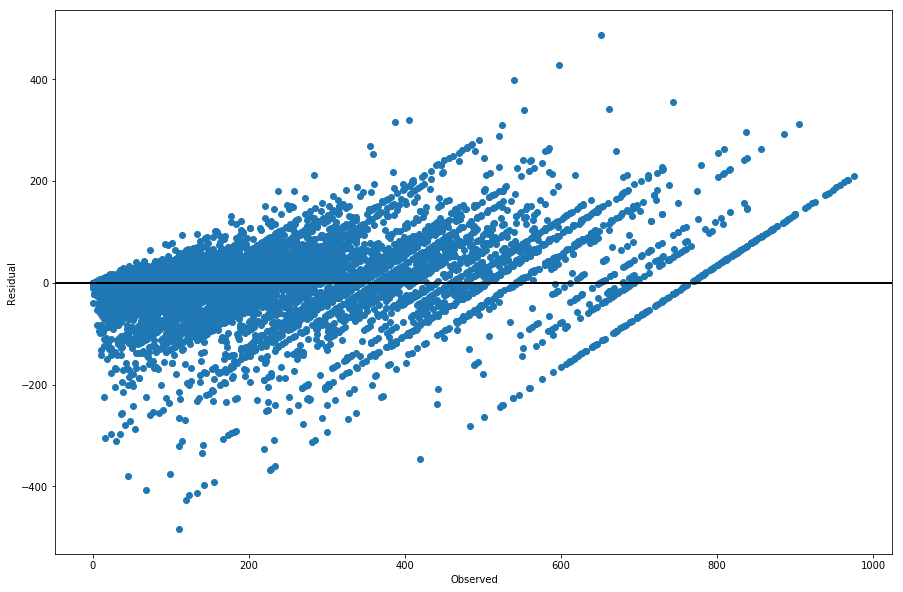

In [30]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(Y,residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')

In [31]:
r2_scores = cross_val_score(grid_cv_cart_model.best_estimator_,X,Y,cv=10)
mse_scores = cross_val_score(grid_cv_cart_model.best_estimator_,X,Y,cv=10, scoring = 'neg_mean_squared_error')

In [32]:
print('R2: {}'.format(np.mean(r2_scores)))
print('MSE: {}'.format(np.mean(mse_scores)))

R2: 0.8634253078970714
MSE: -4546.657974664084


# Testing

In [33]:
best_est = grid_cv_cart_model.best_estimator_

In [37]:
y_pred = best_est.predict(new_x_test)
residuals = new_y_test.flatten() - y_pred

In [39]:
r2_score = best_est.score(new_x_test, new_y_test)
print('R2: {}'.format(r2_score))
print('MSE: {}'.format(mean_squared_error(new_y_test,y_pred)))

R2: 0.8722059567160857
MSE: 4076.815321286291


Text(0,0.5,'Rediduals')

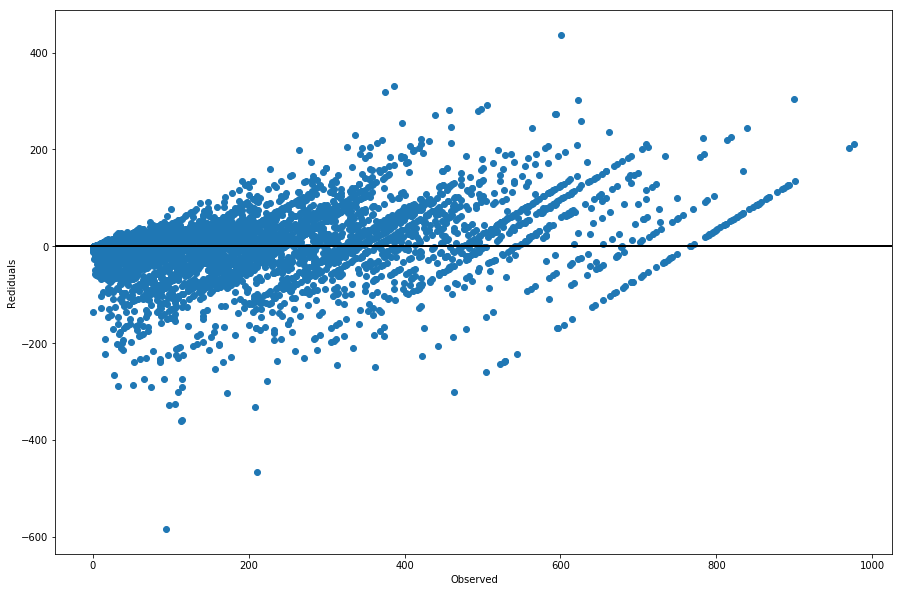

In [40]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(new_y_test,residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Rediduals')

# Improvements to be made
+ Decide if $R^2$, that we got is good enough
+ Fine tune the model further to get better performance
+ Use other non-linear methods and ensemble methods
+ Add pipelines